<a href="https://colab.research.google.com/github/koad7/NLP_PYTORCH/blob/main/Graph_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade -q py2neo
!pip install -q umap-learn
!pip install -q hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.0/177.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import spacy
from scipy.sparse import coo_matrix, save_npz
%matplotlib inline
import pandas as pd

In [5]:
# Download the ZIP file
!wget -P '/content/drive/MyDrive/MSc. DATA SCIENCE/FINAL PROJECT/graph_tuto' https://lp-prod-resources.s3.amazonaws.com/646/109102/2022-07-28-22-18-12/stat-abstract-vectors.tsv.zip
!wget -P '/content/drive/MyDrive/MSc. DATA SCIENCE/FINAL PROJECT/graph_tuto' https://lp-prod-resources.s3.amazonaws.com/646/109102/2022-07-28-22-18-05/stat-abstracts.tsv
# Unzip the file
!unzip stat-abstract-vectors.tsv.zip
# Check the files in the current directory to ensure it's unzipped
!ls





--2023-08-21 12:09:23--  https://lp-prod-resources.s3.amazonaws.com/646/109102/2022-07-28-22-18-12/stat-abstract-vectors.tsv.zip
Resolving lp-prod-resources.s3.amazonaws.com (lp-prod-resources.s3.amazonaws.com)... 52.92.224.97, 52.92.250.33, 52.218.152.171, ...
Connecting to lp-prod-resources.s3.amazonaws.com (lp-prod-resources.s3.amazonaws.com)|52.92.224.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45112095 (43M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/MSc. DATA SCIENCE/FINAL PROJECT/graph_tuto/stat-abstract-vectors.tsv.zip’

stat-abstract-vecto 100%[===================>]  43.02M  12.2MB/s    in 4.5s    

2023-08-21 12:09:28 (9.55 MB/s) - ‘/content/drive/MyDrive/MSc. DATA SCIENCE/FINAL PROJECT/graph_tuto/stat-abstract-vectors.tsv.zip’ saved [45112095/45112095]

--2023-08-21 12:09:28--  https://lp-prod-resources.s3.amazonaws.com/646/109102/2022-07-28-22-18-05/stat-abstracts.tsv
Resolving lp-prod-resources.s3.amazonaws.com (lp-prod-r

In [8]:
DATA_DIR = "/content/drive/MyDrive/MSc. DATA SCIENCE/FINAL PROJECT/graph_tuto"
ABSTRACT_FILE = os.path.join(DATA_DIR, "stat-abstracts.tsv")
ABS_VEC_FILE = os.path.join(DATA_DIR, "stat-abstract-vectors.tsv")
DOCIDS_LIST = os.path.join(DATA_DIR, "stat-av-docids.txt")
SIM_MATRIX_FILE = os.path.join(DATA_DIR, "av-simmatrix.npy")
ADJ_MATRIX_FILE = os.path.join(DATA_DIR, "av-adjmatrix.npz")

## 1-Load the spaCy language model.
We will represent documents as vectors using word embeddings. The spaCy medium and large provides 300-dimensional word vectors out of the box. Documents are represented by vectors that are the average of their word vectors. In our project, we will use the medium English language model (en_core_web_md).



In [9]:
!python -m spacy download en_core_web_md
nlp = spacy.load("en_core_web_md")

2023-08-21 12:10:52.915355: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


## 2-Extract document vectors.
We loop through the abstracts file provided to us, concatenating the title and text for each abstract. Concatenation involves terminating the title with a period and appending the abstract text to the end, essentially treating the title as the first sentence of the resulting text block representing the abstract, and the abstract as the rest. The concatenated text is passed to the spaCy language model. SpaCy will automatically return the average embedding vector described above for each text block.


In [7]:
def join_title_text(title, text):
  joined_text = None
  joined_text = title + ". " + text
  return joined_text

example_joined_text = join_title_text("this is a title", "this is an abstract.")
example_joined_text

'this is a title. this is an abstract.'

In [8]:
def vectorize_text(text, nlp):
  vec = None
  doc = nlp(text)
  vec = doc.vector
  return vec
example_vector = vectorize_text(example_joined_text, nlp)
example_vector.shape

(300,)

In [9]:
num_lines = 0
fabs = open(ABSTRACT_FILE, "r")
fchk = open(ABS_VEC_FILE, "w")
for line in fabs:
  if num_lines % 10000 == 0:
    print("{:d} docs vectorized".format(num_lines))
  doc_id, title, categories, abs_text = line.strip().split('\t')
  vec_str = None
  ## Generate the vector from the title and abstract, and stringify the vector elements
  ## into vec_str. Each element should be represented in floating point or exponential
  ## notation to 3 decimal places, and elements should be joined using commas (,).
  vec = vectorize_text(join_title_text(title, abs_text), nlp)
  vec_str = ",".join(["{:.3e}".format(v) for v in vec.tolist()])
  fchk.write("{:s}\t{:s}\n".format(doc_id, vec_str))
  num_lines += 1
print("{:d} docs vectorized, COMPLETE".format(num_lines))
fchk.close()
fabs.close()

0 docs vectorized
10000 docs vectorized
20000 docs vectorized
30000 docs vectorized
40000 docs vectorized
50000 docs vectorized
50426 docs vectorized, COMPLETE


### 3. Construct a dense document matrix

Use the file of vectors generated (indicated by `ABS_VEC_FILE`) and create a list of document IDs (`docids`) and a list of vectors (`vecs`). Each element of the list `vecs` must be a numpy array of size (300,).

The next cell displays the size of the `docids` and `vecs` list. Verify that they are identical. Also verify that the elements of the list `vecs` are numpy vectors of size (300,).



In [10]:
docids, vecs = [], []
with open(ABS_VEC_FILE, "r") as fav:
    num_recs = 0
    for line in fav:
        if num_recs % 10000 == 0:
            print("{:d} vectors read".format(num_recs))
        doc_id, vec_str = line.strip().split('\t')
        vec = np.array([float(x) for x in vec_str.split(",")])
        vecs.append(vec)
        docids.append(doc_id)
        num_recs += 1

print("{:d} vectors read, COMPLETE".format(num_recs))

0 vectors read
10000 vectors read
20000 vectors read
30000 vectors read
40000 vectors read
50000 vectors read
50426 vectors read, COMPLETE


In [11]:
print("number of docIDs:", len(docids))
print("number of vectors:", len(vecs))
print("shape of vector in vecs:", vecs[0].shape)

number of docIDs: 50426
number of vectors: 50426
shape of vector in vecs: (300,)


We now convert the list of (300,) vectors into a matrix of documents. There are 50426 documents in the corpus, so verify that the shape of the matrix is (50426, 300).

In [12]:
X = np.array(vecs)
X.shape

(50426, 300)

### 4. Construct a document similarity matrix

We use cosine similarity as our similarity measure. The formula for cosine similarity between a pair of documents vectors $d_1$ and $d_2$ is given by:

$$cosim(d_1, d_2) = \frac{d_1 \cdot d_2}{{\lvert d_1 \rvert}_2 {\lvert d_2 \rvert}_2}$$

We can also compute the cosine similarity between all pairs of documents in the document matrix X using the following formula.

$$S = \frac{X \cdot X^T}{{\lvert X \rvert}_2^2}$$

Since the denominator on the RHS is a constant, we can re-state the equation above as:

$$S \propto X \cdot X^T$$



**NOTE: this is a time consuming operation. If you would rather skip this, please download the serialized version of the similarity matrix from the code repository for this liveProject and load it into the variable `S` by uncommenting the commented code in the next cell instead (the one containing S = np.load(SIM_MATRIX_FILE).**

```
wget http://download.location/.../av-simmatrix.npy .
```


In [13]:
S = np.dot(X, X.T)
S.shape

(50426, 50426)

## 5-Determine similarity threshold.
- The resulting similarity matrix is dense since the document vectors are dense as well. If we built a graph out of this, it would be extremely dense and not provide us with meaningful insights. So we need to establish a similarity threshold above which we will consider a document pair to be related, and below which they would be considered unrelated.
- We do this by sampling from the similarity matrix and building a histogram of scores. We determine the threshold by inspecting the histogram. The objective is to build an adjacency matrix that represents a graph that is sparse enough to provide a meaningful structure. That is, we connect two documents only if there is a very high similarity.
- Unfortunately, this is somewhat subjective and you might need a few attempts with different thresholds in order to get a meaningful threshold.
- Building the histogram against the full document set is quite compute-intensive, so to enable quick development cycles, we sample about 2% of the data (1000 documents) randomly and generate the histogram from it.
- A good rule of thumb might be to set the threshold to only include edges with weights that are in the top 1–5% of the population.



We sample around 1000 elements from the similarity matrix and plot a histogram to get an idea of the distribution of cosine similarity scores.

We want to draw edges only between documents with relatively high similarity. Based on the histogram, a good threshold seems to be 9.5.

(array([  6.,   3.,  10.,  28.,  75., 222., 317., 247.,  86.,   6.]),
 array([ 376.72483202,  469.06694399,  561.40905597,  653.75116795,
         746.09327993,  838.43539191,  930.77750389, 1023.11961587,
        1115.46172785, 1207.80383983, 1300.14595181]),
 <BarContainer object of 10 artists>)

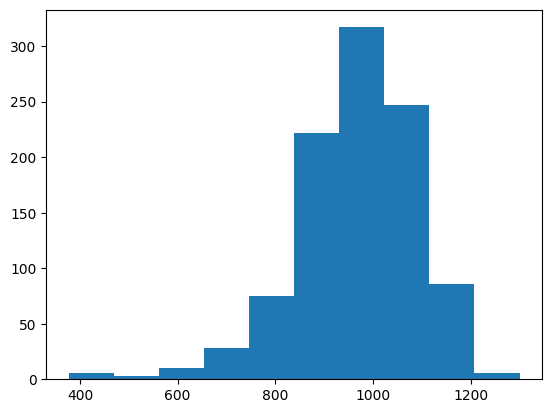

In [14]:
row_indices = np.random.randint(0, S.shape[0], 1000)
col_indices = np.random.randint(0, S.shape[1], 1000)
samples = []
for row, col in zip(row_indices, col_indices):
    samples.append(S[row, col])

plt.hist(samples)


## 6-Create an adjacency matrix.
Remember to set the diagonal to zero. A document is most similar to itself, therefore diagonal elements would be highest, but we are not interested in this relation for our graph.
Update the similarity matrix such that any value above the threshold is 1 and any values below it are 0.



We can now create an adjacency matrix `A` from the similarity matrix `S`. An adjacency matrix is a square matrix of the same size as the similarity matrix, i.e. an (N, N) matrix where N is the number of documents. An element `A[i, j]` is 1 if there is high similarity between $doc_i$ and $doc_j$, i.e. similarity above the threshold.

Also remember to set the diagonal elements of the adjacency matrix to 0. For similarity matrices, the highest values are on the diagonal, since a document is most similar to itself. However, that would translate to self-loops in a graph, which we don't care about.

In [2]:
threshold = 9.5

A = np.zeros(S.shape)
ones_indices = S >= threshold
A[ones_indices] = 1

np.fill_diagonal(A, 0)

NameError: ignored

## 7-Save the adjacency matrix for the next milestone.
Remember to save the adjacency matrix representing the document graph for the next milestone. We will need the adjacency matrix and a pointer from each row position back to the document ID.

In [1]:
# np.save(ADJ_MATRIX_FILE, A)
save_npz(ADJ_MATRIX_FILE, coo_matrix(A.astype(np.int8)))

NameError: ignored

In [ ]:
fdocs = open(DOCIDS_LIST, "w")
for i, doc_id in enumerate(docids):
    fdocs.write("{:s}\t{:d}\n".format(doc_id, i))
fdocs.close()